In [1]:
import multiprocessing
import threading
import tensorflow as tf
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
GAME = 'Pendulum-v0'
OUTPUT_GRAPH = True
LOG_DIR = './log'
N_WORKERS = multiprocessing.cpu_count()
MAX_EP_STEP = 200
MAX_GLOBAL_EP = 2000
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 10
GAMMA = 0.9
ENTROPY_BETA = 0.01
LR_A = 0.0001    # learning rate for actor
LR_C = 0.001    # learning rate for critic
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0


In [3]:
env = gym.make(GAME)

N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
A_BOUND = [env.action_space.low, env.action_space.high]


In [4]:
class ACNet(object):
    def __init__(self, scope, globalAC=None):

        if scope == GLOBAL_NET_SCOPE:   # get global network
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_params, self.c_params = self._build_net(scope)[-2:]
        else:   # local net, calculate losses
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_his = tf.placeholder(tf.float32, [None, N_A], 'A')
                self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')

                mu, sigma, self.v, self.a_params, self.c_params = self._build_net(scope)

                td = tf.subtract(self.v_target, self.v, name='TD_error')
                with tf.name_scope('c_loss'):
                    self.c_loss = tf.reduce_mean(tf.square(td))

                with tf.name_scope('wrap_a_out'):
                    mu, sigma = mu * A_BOUND[1], sigma + 1e-4

                normal_dist = tf.distributions.Normal(mu, sigma)

                with tf.name_scope('a_loss'):
                    log_prob = normal_dist.log_prob(self.a_his)
                    exp_v = log_prob * tf.stop_gradient(td)
                    entropy = normal_dist.entropy()  # encourage exploration
                    self.exp_v = ENTROPY_BETA * entropy + exp_v
                    self.a_loss = tf.reduce_mean(-self.exp_v)

                with tf.name_scope('choose_a'):  # use local params to choose action
                    self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=[0, 1]), A_BOUND[0], A_BOUND[1])
                with tf.name_scope('local_grad'):
                    self.a_grads = tf.gradients(self.a_loss, self.a_params)
                    self.c_grads = tf.gradients(self.c_loss, self.c_params)

            with tf.name_scope('sync'):
                with tf.name_scope('pull'):
                    self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
                    self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
                with tf.name_scope('push'):
                    self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
                    self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))

    def _build_net(self, scope):
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('actor'):
            l_a = tf.layers.dense(self.s, 200, tf.nn.relu6, kernel_initializer=w_init, name='la')
            mu = tf.layers.dense(l_a, N_A, tf.nn.tanh, kernel_initializer=w_init, name='mu')
            sigma = tf.layers.dense(l_a, N_A, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
        with tf.variable_scope('critic'):
            l_c = tf.layers.dense(self.s, 100, tf.nn.relu6, kernel_initializer=w_init, name='lc')
            v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')  # state value
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        return mu, sigma, v, a_params, c_params

    def update_global(self, feed_dict):  # run by a local
        SESS.run([self.update_a_op, self.update_c_op], feed_dict)  # local grads applies to global net

    def pull_global(self):  # run by a local
        SESS.run([self.pull_a_params_op, self.pull_c_params_op])

    def choose_action(self, s):  # run by a local
        s = s[np.newaxis, :]
        return SESS.run(self.A, {self.s: s})



In [5]:
class Worker(object):
    def __init__(self, name, globalAC):
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)

    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            for ep_t in range(MAX_EP_STEP):
                # if self.name == 'W_0':
                #     self.env.render()
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                done = True if ep_t == MAX_EP_STEP - 1 else False

                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append((r+8)/8)    # normalize

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:   # update global and assign to local net
                    if done:
                        v_s_ = 0   # terminal
                    else:
                        v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :]})[0, 0]
                    buffer_v_target = []
                    for r in buffer_r[::-1]:    # reverse buffer r
                        v_s_ = r + GAMMA * v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()

                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_v_target)
                    feed_dict = {
                        self.AC.s: buffer_s,
                        self.AC.a_his: buffer_a,
                        self.AC.v_target: buffer_v_target,
                    }
                    self.AC.update_global(feed_dict)
                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()

                s = s_
                total_step += 1
                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
                    print(
                        self.name,
                        "Ep:", GLOBAL_EP,
                        "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                          )
                    GLOBAL_EP += 1
                    break

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W_1 Ep: 0 | Ep_r: -1343
W_2 Ep: 1 | Ep_r: -1395
W_3 Ep: 2 | Ep_r: -1412
W_0 Ep: 3 | Ep_r: -1425
W_2 Ep: 4 | Ep_r: -1453
W_3 Ep: 5 | Ep_r: -1445
W_1 Ep: 6 | Ep_r: -1453
W_0 Ep: 7 | Ep_r: -1473
W_3 Ep: 8 | Ep_r: -1503
W_2 Ep: 9 | Ep_r: -1505
W_0 Ep: 10 | Ep_r: -1507
W_1 Ep: 11 | Ep_r: -1510
W_2 Ep: 12 | Ep_r: -1516
W_3 Ep: 13 | Ep_r: -1513
W_0 Ep: 14 | Ep_r: -1539
W_1 Ep: 15 | Ep_r: -1559
W_2 Ep:

W_3 Ep: 269 | Ep_r: -895
W_0 Ep: 270 | Ep_r: -871
W_1 Ep: 271 | Ep_r: -885
W_2 Ep: 272 | Ep_r: -884
W_3 Ep: 273 | Ep_r: -893
W_0 Ep: 274 | Ep_r: -866
W_1 Ep: 275 | Ep_r: -868
W_2 Ep: 276 | Ep_r: -869
W_3 Ep: 277 | Ep_r: -858
W_0 Ep: 278 | Ep_r: -904
W_1 Ep: 279 | Ep_r: -923
W_2 Ep: 280 | Ep_r: -930
W_3 Ep: 281 | Ep_r: -913
W_0 Ep: 282 | Ep_r: -914
W_1 Ep: 283 | Ep_r: -916
W_2 Ep: 284 | Ep_r: -916
W_3 Ep: 285 | Ep_r: -929
W_0 Ep: 286 | Ep_r: -926
W_1 Ep: 287 | Ep_r: -908
W_2 Ep: 288 | Ep_r: -920
W_3 Ep: 289 | Ep_r: -914
W_0 Ep: 290 | Ep_r: -894
W_1 Ep: 291 | Ep_r: -919
W_2 Ep: 292 | Ep_r: -893
W_3 Ep: 293 | Ep_r: -880
W_0 Ep: 294 | Ep_r: -872
W_1 Ep: 295 | Ep_r: -880
W_2 Ep: 296 | Ep_r: -856
W_3 Ep: 297 | Ep_r: -857
W_0 Ep: 298 | Ep_r: -835
W_1 Ep: 299 | Ep_r: -821
W_2 Ep: 300 | Ep_r: -815
W_3 Ep: 301 | Ep_r: -836
W_0 Ep: 302 | Ep_r: -845
W_1 Ep: 303 | Ep_r: -838
W_2 Ep: 304 | Ep_r: -827
W_0 Ep: 305 | Ep_r: -811
W_3 Ep: 306 | Ep_r: -821
W_1 Ep: 307 | Ep_r: -848
W_2 Ep: 308 | Ep_r: -869


W_2 Ep: 600 | Ep_r: -574
W_0 Ep: 601 | Ep_r: -572
W_3 Ep: 602 | Ep_r: -570
W_1 Ep: 603 | Ep_r: -576
W_2 Ep: 604 | Ep_r: -545
W_0 Ep: 605 | Ep_r: -572
W_3 Ep: 606 | Ep_r: -554
W_1 Ep: 607 | Ep_r: -566
W_2 Ep: 608 | Ep_r: -509
W_0 Ep: 609 | Ep_r: -511
W_3 Ep: 610 | Ep_r: -526
W_1 Ep: 611 | Ep_r: -540
W_2 Ep: 612 | Ep_r: -539
W_0 Ep: 613 | Ep_r: -525
W_3 Ep: 614 | Ep_r: -525
W_1 Ep: 615 | Ep_r: -511
W_2 Ep: 616 | Ep_r: -539
W_0 Ep: 617 | Ep_r: -508
W_3 Ep: 618 | Ep_r: -541
W_1 Ep: 619 | Ep_r: -558
W_2 Ep: 620 | Ep_r: -555
W_0 Ep: 621 | Ep_r: -526
W_3 Ep: 622 | Ep_r: -553
W_1 Ep: 623 | Ep_r: -551
W_2 Ep: 624 | Ep_r: -561
W_0 Ep: 625 | Ep_r: -559
W_3 Ep: 626 | Ep_r: -577
W_1 Ep: 627 | Ep_r: -599
W_2 Ep: 628 | Ep_r: -631
W_0 Ep: 629 | Ep_r: -642
W_3 Ep: 630 | Ep_r: -641
W_1 Ep: 631 | Ep_r: -616
W_2 Ep: 632 | Ep_r: -620
W_0 Ep: 633 | Ep_r: -597
W_3 Ep: 634 | Ep_r: -605
W_1 Ep: 635 | Ep_r: -575
W_2 Ep: 636 | Ep_r: -545
W_0 Ep: 637 | Ep_r: -543
W_3 Ep: 638 | Ep_r: -515
W_1 Ep: 639 | Ep_r: -490


W_2 Ep: 930 | Ep_r: -540
W_1 Ep: 931 | Ep_r: -541
W_3 Ep: 932 | Ep_r: -541
W_0 Ep: 933 | Ep_r: -582
W_2 Ep: 934 | Ep_r: -595
W_1 Ep: 935 | Ep_r: -549
W_0 Ep: 936 | Ep_r: -561
W_3 Ep: 937 | Ep_r: -574
W_2 Ep: 938 | Ep_r: -594
W_1 Ep: 939 | Ep_r: -614
W_0 Ep: 940 | Ep_r: -566
W_3 Ep: 941 | Ep_r: -600
W_2 Ep: 942 | Ep_r: -630
W_1 Ep: 943 | Ep_r: -630
W_0 Ep: 944 | Ep_r: -607
W_3 Ep: 945 | Ep_r: -599
W_2 Ep: 946 | Ep_r: -580
W_1 Ep: 947 | Ep_r: -584
W_0 Ep: 948 | Ep_r: -580
W_3 Ep: 949 | Ep_r: -548
W_1 Ep: 950 | Ep_r: -507
W_2 Ep: 951 | Ep_r: -495
W_3 Ep: 952 | Ep_r: -506
W_0 Ep: 953 | Ep_r: -496
W_1 Ep: 954 | Ep_r: -472
W_2 Ep: 955 | Ep_r: -479
W_0 Ep: 956 | Ep_r: -458
W_3 Ep: 957 | Ep_r: -438
W_2 Ep: 958 | Ep_r: -421
W_1 Ep: 959 | Ep_r: -392
W_0 Ep: 960 | Ep_r: -409
W_3 Ep: 961 | Ep_r: -422
W_2 Ep: 962 | Ep_r: -461
W_1 Ep: 963 | Ep_r: -468
W_0 Ep: 964 | Ep_r: -448
W_3 Ep: 965 | Ep_r: -430
W_2 Ep: 966 | Ep_r: -413
W_1 Ep: 967 | Ep_r: -432
W_0 Ep: 968 | Ep_r: -444
W_3 Ep: 969 | Ep_r: -442


W_3 Ep: 1251 | Ep_r: -264
W_2 Ep: 1252 | Ep_r: -297
W_1 Ep: 1253 | Ep_r: -294
W_0 Ep: 1254 | Ep_r: -322
W_3 Ep: 1255 | Ep_r: -343
W_2 Ep: 1256 | Ep_r: -336
W_1 Ep: 1257 | Ep_r: -302
W_0 Ep: 1258 | Ep_r: -350
W_3 Ep: 1259 | Ep_r: -315
W_2 Ep: 1260 | Ep_r: -297
W_1 Ep: 1261 | Ep_r: -344
W_0 Ep: 1262 | Ep_r: -337
W_3 Ep: 1263 | Ep_r: -329
W_2 Ep: 1264 | Ep_r: -381
W_1 Ep: 1265 | Ep_r: -400
W_0 Ep: 1266 | Ep_r: -453
W_2 Ep: 1267 | Ep_r: -420
W_3 Ep: 1268 | Ep_r: -431
W_1 Ep: 1269 | Ep_r: -428
W_0 Ep: 1270 | Ep_r: -426
W_2 Ep: 1271 | Ep_r: -464
W_3 Ep: 1272 | Ep_r: -459
W_1 Ep: 1273 | Ep_r: -439
W_0 Ep: 1274 | Ep_r: -475
W_3 Ep: 1275 | Ep_r: -467
W_2 Ep: 1276 | Ep_r: -449
W_1 Ep: 1277 | Ep_r: -460
W_0 Ep: 1278 | Ep_r: -485
W_3 Ep: 1279 | Ep_r: -450
W_2 Ep: 1280 | Ep_r: -420
W_1 Ep: 1281 | Ep_r: -443
W_0 Ep: 1282 | Ep_r: -480
W_3 Ep: 1283 | Ep_r: -459
W_2 Ep: 1284 | Ep_r: -490
W_1 Ep: 1285 | Ep_r: -483
W_0 Ep: 1286 | Ep_r: -476
W_3 Ep: 1287 | Ep_r: -455
W_2 Ep: 1288 | Ep_r: -501
W_1 Ep: 1289

W_0 Ep: 1570 | Ep_r: -310
W_3 Ep: 1571 | Ep_r: -306
W_2 Ep: 1572 | Ep_r: -315
W_1 Ep: 1573 | Ep_r: -296
W_0 Ep: 1574 | Ep_r: -308
W_3 Ep: 1575 | Ep_r: -318
W_2 Ep: 1576 | Ep_r: -312
W_1 Ep: 1577 | Ep_r: -366
W_0 Ep: 1578 | Ep_r: -329
W_3 Ep: 1579 | Ep_r: -309
W_2 Ep: 1580 | Ep_r: -321
W_1 Ep: 1581 | Ep_r: -315
W_0 Ep: 1582 | Ep_r: -376
W_3 Ep: 1583 | Ep_r: -437
W_2 Ep: 1584 | Ep_r: -472
W_1 Ep: 1585 | Ep_r: -490
W_0 Ep: 1586 | Ep_r: -534
W_3 Ep: 1587 | Ep_r: -507
W_2 Ep: 1588 | Ep_r: -560
W_1 Ep: 1589 | Ep_r: -517
W_0 Ep: 1590 | Ep_r: -465
W_2 Ep: 1591 | Ep_r: -432
W_3 Ep: 1592 | Ep_r: -402
W_1 Ep: 1593 | Ep_r: -426
W_0 Ep: 1594 | Ep_r: -397
W_2 Ep: 1595 | Ep_r: -370
W_3 Ep: 1596 | Ep_r: -374
W_1 Ep: 1597 | Ep_r: -400
W_0 Ep: 1598 | Ep_r: -401
W_3 Ep: 1599 | Ep_r: -400
W_2 Ep: 1600 | Ep_r: -416
W_1 Ep: 1601 | Ep_r: -388
W_0 Ep: 1602 | Ep_r: -349
W_3 Ep: 1603 | Ep_r: -353
W_2 Ep: 1604 | Ep_r: -331
W_1 Ep: 1605 | Ep_r: -325
W_0 Ep: 1606 | Ep_r: -305
W_3 Ep: 1607 | Ep_r: -314
W_2 Ep: 1608

W_2 Ep: 1887 | Ep_r: -480
W_3 Ep: 1888 | Ep_r: -498
W_1 Ep: 1889 | Ep_r: -501
W_0 Ep: 1890 | Ep_r: -464
W_2 Ep: 1891 | Ep_r: -444
W_3 Ep: 1892 | Ep_r: -399
W_1 Ep: 1893 | Ep_r: -373
W_0 Ep: 1894 | Ep_r: -348
W_2 Ep: 1895 | Ep_r: -340
W_3 Ep: 1896 | Ep_r: -320
W_1 Ep: 1897 | Ep_r: -314
W_0 Ep: 1898 | Ep_r: -296
W_2 Ep: 1899 | Ep_r: -340
W_3 Ep: 1900 | Ep_r: -373
W_1 Ep: 1901 | Ep_r: -388
W_0 Ep: 1902 | Ep_r: -375
W_2 Ep: 1903 | Ep_r: -364
W_3 Ep: 1904 | Ep_r: -341
W_1 Ep: 1905 | Ep_r: -334
W_0 Ep: 1906 | Ep_r: -339
W_3 Ep: 1907 | Ep_r: -306
W_2 Ep: 1908 | Ep_r: -316
W_1 Ep: 1909 | Ep_r: -311
W_0 Ep: 1910 | Ep_r: -320
W_2 Ep: 1911 | Ep_r: -344
W_3 Ep: 1912 | Ep_r: -363
W_1 Ep: 1913 | Ep_r: -327
W_0 Ep: 1914 | Ep_r: -352
W_3 Ep: 1915 | Ep_r: -357
W_2 Ep: 1916 | Ep_r: -405
W_1 Ep: 1917 | Ep_r: -431
W_0 Ep: 1918 | Ep_r: -401
W_3 Ep: 1919 | Ep_r: -387
W_2 Ep: 1920 | Ep_r: -388
W_1 Ep: 1921 | Ep_r: -407
W_0 Ep: 1922 | Ep_r: -405
W_2W_3 Ep: 1923 | Ep_r: -429
 Ep: 1923 | Ep_r: -446
W_1 Ep: 1925

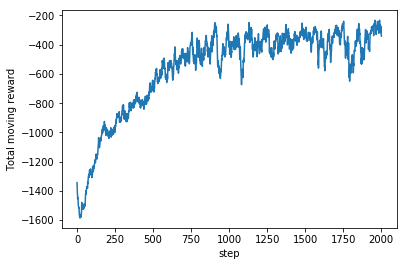

In [6]:
SESS = tf.Session()

with tf.device("/cpu:0"):
    OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
    OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
    GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
    workers = []
    # Create worker
    for i in range(N_WORKERS):
        i_name = 'W_%i' % i   # worker name
        workers.append(Worker(i_name, GLOBAL_AC))

COORD = tf.train.Coordinator()
SESS.run(tf.global_variables_initializer())

if OUTPUT_GRAPH:
    if os.path.exists(LOG_DIR):
        shutil.rmtree(LOG_DIR)
    tf.summary.FileWriter(LOG_DIR, SESS.graph)

worker_threads = []
for worker in workers:
    job = lambda: worker.work()
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
COORD.join(worker_threads)

plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
plt.xlabel('step')
plt.ylabel('Total moving reward')
plt.show()